In [1]:
%matplotlib inline
from datetime import datetime

import numpy as np
import pandas as pd
from typing import Literal
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

templates = {
    "jp": "Y/M/D H:m - U: ",
    "en-uk": "D/M/Y, H:m - U: ",
}


def numBetween(num: str, minimum: int, maximum: int) -> bool:
    if num.isnumeric():
        return minimum <= int(num) <= maximum
    else:
        return False


def parse(data: str) -> list:
    default_template = ""
    output = []
    for line in data.splitlines():
        line_output = {
            "day": 0,
            "month": 0,
            "year": 0,
            "hour": 0,
            "minute": 0,
            "user": "",
            "msgLen": ""
        }
        # print(line)
        for key in templates:
            i = 0
            j = 0
            if (output != []) and (key != default_template):
                continue
            for char in templates[key]:
                # print(char)
                match char:
                    # Two-digit day
                    case "D":
                        if numBetween(line[i:i + 2], 1, 31):
                            line_output["day"] = line[i:i + 2]
                            i += 2
                        else:
                            break
                    # Two-digit month
                    case "M":
                        if numBetween(line[i:i + 2], 1, 12):
                            line_output["month"] = line[i:i + 2]
                            i += 2
                        else:
                            break
                    # Four-digit year
                    case "Y":
                        if numBetween(line[i:i + 4], 1816, 3016):
                            line_output["year"] = line[i:i + 4]
                            i += 4
                        else:
                            break
                    # Two-digit hour
                    case "H":
                        if numBetween(line[i:i + 2], 0, 23):
                            line_output["hour"] = line[i:i + 2]
                            i += 2
                        else:
                            break
                    # Two-digit minute
                    case "m":
                        if numBetween(line[i:i + 2], 0, 59):
                            line_output["minute"] = line[i:i + 2]
                            i += 2
                        else:
                            break
                    # Username
                    case "U":
                        if line.find(":", i) != -1:
                            n = line.find(":", i)
                            line_output["user"] = line[i:n]
                            i = n
                        else:
                            line_output["user"] = "System message"
                            j = len(templates[key])
                            break
                    # Everything else
                    case _:
                        if line[i] == char:
                            i += 1
                        else:
                            break
                j += 1
            if j == len(templates[key]):
                line_output["msgLen"] = len(line) - i
                default_template = key
        if default_template != "" \
                and line_output["user"] != "":
            dt = datetime.strptime(str(line_output["day"]) + "-" +
                               str(line_output["month"]) + "-" +
                               str(line_output["year"]) + " " +
                               str(line_output["hour"]) + "-" +
                               str(line_output["minute"]), '%d-%m-%Y %H-%M')
            line_output["datetime"] = dt.strftime('%Y-%m-%d %H:%M')
            line_output["count"] = 1
            output.append(line_output)
        elif line == data.splitlines()[-1]:
            raise ValueError("This file was exported in an unsupported language.")
    # print(output)
    # print(len(output))
    # print(default_template)
    return output


def resample(data: list, td: pd.Timedelta):
    df = pd.DataFrame(data)
    df["datetime"] = pd.to_datetime(df["datetime"], format='%Y-%m-%d %H:%M')
    out = df.set_index("datetime").resample(td).count()
    out = out[["count"]]
    # print(df)
    # print(out)
    return out


DATA_TYPES = Literal["raw", "bars", "box"]


# result = []
#
# dailyBars = None
# dailyBox = None
# dailyRaw = None
#
# hourlyBars = None
# hourlyBox = None
# hourlyRaw = None

file = open("another.txt", "r").read()
result = parse(file)
# dailyBars = daily(resample(result, "D"), "bars")
# dailyBox = daily(resample(result, "D"), "box")
# dailyRaw = daily(resample(result, "D"), "raw")
# matplotlib.pyplot.show()
# hourlyBars = hourly(resample(result, "h"), "bars")
# hourlyBox = hourly(resample(result, "h"), "box")
# hourlyRaw = hourly(resample(result, "h"), "raw")
# matplotlib.pyplot.show()


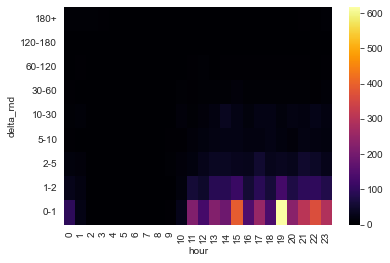

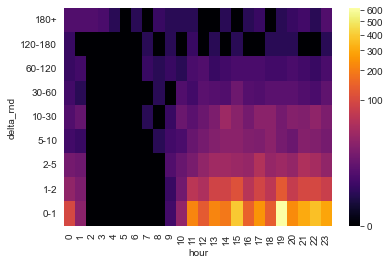

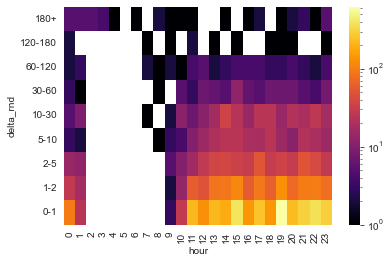

In [2]:
import matplotlib


def heatmap(data):
    bins = [0, 1, 2, 5, 10, 30, 60, 120, 180]
    names = ['0-1', "1-2", '2-5', "5-10", "10-30", "30-60", "60-120", "120-180", "180+"]
    tags = ["180+", "120-180", "60-120", "30-60", "10-30", "5-10", '2-5', "1-2", '0-1']
    d = dict(enumerate(names, 1))
    df = pd.DataFrame(data)
    df["datetime"] = pd.to_datetime(df["datetime"], format='%Y-%m-%d %H:%M')
    df = df.set_index("datetime")
    df['datetime'] = df.index
    df['delta'] = (df['datetime'] - df['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
    df["delta"] = df['delta'].dt.total_seconds().div(60).astype(int)
    # return df
    df["hour"] = df.index.hour
    df["hour"] = df["hour"].shift(1)
    df = df.drop(['datetime'], axis=1)
    df = df.loc[df["user"].shift(1) != df["user"]]
    df['delta_rnd'] = np.vectorize(d.get)(np.digitize(df['delta'], bins))
    df_user = df
    df_user['count'] = 1
    df2 = df_user.groupby(['delta_rnd','hour'], as_index=False).count()

    df_p = pd.pivot_table(df2, 'count', 'delta_rnd', 'hour')
    df_p = df_p.reindex(index=tags)
    df_p.columns = df_p.columns.astype(int)

    TEMP_COL_COUNTER = 0
    for column in df_p:
        if TEMP_COL_COUNTER != column:
            df_p.insert(TEMP_COL_COUNTER, TEMP_COL_COUNTER, np.nan)
            TEMP_COL_COUNTER += 1
        TEMP_COL_COUNTER += 1
    # df_p.iloc[:,5] = np.nan
    df_p = df_p.replace(np.nan, 0)
    return df_p

MAP = "inferno"

delayHeatmap = heatmap(result)
sns.heatmap(delayHeatmap, cmap=MAP)
plt.show()
sns.heatmap(delayHeatmap, cmap=MAP, norm=matplotlib.colors.PowerNorm(gamma=0.3))
plt.show()
sns.heatmap(delayHeatmap, cmap=MAP, norm=matplotlib.colors.LogNorm())
plt.show()

In [3]:
df = pd.DataFrame(result)

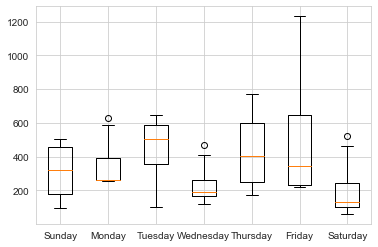

In [4]:

scaler = preprocessing.QuantileTransformer()
from scipy import stats
from matplotlib.cbook import boxplot_stats


def daily(data, group: DATA_TYPES):
    data['weekday'] = data.index.day_name()
    data['day'] = data.index
    data = data.pivot(index='day', columns='weekday', values='count')
    data = data[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', ]]
    match group:
        case "raw":
            return data
        case "bars":
            return data.mean()\
                .rename_axis('day')\
                .reset_index()\
                .rename(columns={0: "mean"})
        case "box":
            # print(data.reset_index(drop=True))
            # mask = ~np.isnan(data.reset_index(drop=True))
            # filtered_data = [d[m] for d, m in zip(data.reset_index(drop=True).T, mask.T)]
            return boxify(data)
            #### return sns.boxplot(data=data, showfliers=False)
            # data["summed"] = data.apply(lambda r: r.sum(), axis=1)
            # data = data.reset_index(drop=True).drop(columns=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', ])
            # scaled_data = scaler.fit_transform(data)
            # return sns.histplot(data=data)


def dailyTEST(data, group: DATA_TYPES):
    data['weekday'] = data.index.day_name()
    data['day'] = data.index
    data = data.pivot(index='day', columns='weekday', values='count')
    data = data[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', ]]
    match group:
        case "raw":
            return data
        case "bars":
            data = data.mean()\
                .rename_axis('day')\
                .reset_index()\
                .rename(columns={0: "mean"})
            return sns.barplot(data=data)
        case "box":
            # print(data.reset_index(drop=True))
            # mask = ~np.isnan(data.reset_index(drop=True))
            # filtered_data = [d[m] for d, m in zip(data.reset_index(drop=True).T, mask.T)]
            # data = data[(np.abs(stats.zscore(data, nan_policy="omit")) < 2)]

            # return data.values
            # return sns.violinplot(data=data, cut=0)
            return boxify(data)
            # return sns.boxplot(data=data, showfliers=True)

            # data["summed"] = data.apply(lambda r: r.sum(), axis=1)
            # data = data.reset_index(drop=True).drop(columns=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', ])
            # scaled_data = scaler.fit_transform(data)
            # return sns.histplot(data=scaled_data)


def boxify(data: pd.DataFrame) -> pd.DataFrame:
    df = data.describe(percentiles=[.25, .5, .75])
    df.loc["iqr"] = df.loc['75%'] - df.loc['25%']

    df.loc["lwhisk"] = df.loc['25%'] - 1.5 * df.loc['iqr']
    def checkMin(r):
        # if r.loc["min"].gt(r.loc["lwhisk"]):
        if r.loc["min"] >= (r.loc['25%'] - 1.5 * r.loc['iqr']):
            return r.loc["min"]
        else:
            return r.loc['25%'] - 1.5 * r.loc['iqr']
    df.loc["lwhisk"] = df.apply(checkMin, axis=0)

    df.loc["uwhisk"] = df.loc['75%'] + 1.5 * df.loc['iqr']
    def checkMax(r):
        # if r.loc["min"].gt(r.loc["lwhisk"]):
        if r.loc["max"] <= (r.loc['75%'] + 1.5 * r.loc['iqr']):
            return r.loc["max"]
        else:
            return r.loc['75%'] + 1.5 * r.loc['iqr']
    df.loc["uwhisk"] = df.apply(checkMax, axis=0)

    df[df < 0] = 0
    df_outliers = data[(data > df.loc['uwhisk']) | (data < df.loc['lwhisk'])].dropna(how='all')
    outliers = df_outliers.T.values.tolist()
    outliers = np.array([[x for x in y if not np.isnan(x)] for y in outliers], dtype=object)
    df.loc["outliers"] = outliers
    return df

def hourly(data, group: DATA_TYPES):
    data['hour'] = data.index.hour
    data['day'] = data.index
    data = data.pivot(index='day', columns='hour', values='count')
    match group:
        case "raw":
            return data
            # data["summed"] = data.apply(lambda r: r.sum(), axis=1)
            # return data.reset_index(drop=True).drop(
            #     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
        case "bars":
            return data.mean()\
                .rename_axis('hour')\
                .reset_index()\
                .rename(columns={0: "mean"})
        case "box":
            return boxify(data)
            # data["summed"] = data.apply(lambda r: r.sum(), axis=1)
            # data = data.reset_index(drop=True).drop(columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
            # data = scaler.fit_transform(data)
            # return sns.histplot(data=data)

dailyBars = daily(resample(result, "D"), "bars")
dailyBox = daily(resample(result, "D"), "box")
dailyRaw = daily(resample(result, "D"), "raw")

ANOTHERDAILY = dailyTEST(resample(result, "D"), "box")
plt.show()
# hourlyBars = hourly(resample(result, "h"), "bars")
# hourlyBox = hourly(resample(result, "h"), "box")
# hourlyRaw = hourly(resample(result, "h"), "raw")
# plt.show()
fig, ax = plt.subplots()
boxes = []
for (col, content) in dailyBox.iteritems():
   boxes.append({
       'label' : col,
       'whislo': dailyBox.loc["lwhisk", col],
       'q1'    : dailyBox.loc["25%", col],
       'med'   : dailyBox.loc["50%", col],
       'q3'    : dailyBox.loc["75%", col],
       'whishi': dailyBox.loc["uwhisk", col],
       'fliers': dailyBox.loc["outliers", col]
   })
ax.bxp(boxes, showfliers=True)
plt.show()

In [7]:
def users(data: list):
    # maybe users
    return pd.DataFrame(data).groupby(['user'], as_index=False).count()[["user", "count"]].set_index("user")


USUARIOS = users(result)